# 2024 Monaco Grand Prix Qualifying

The 2024 Monaco Grand Prix was held on 26 May 2024, at the Circuit de Monaco in Monaco. Charles Leclerc from Ferrari took the pole position and won the race. He was followed closely by McLaren-Mercedes Oscar Piastri in the 2nd position who finished on 2nd position in qualyfying as well by a narrow margin of 0.154 seconds.

### The Fast-F1 library

The Fast-F1 library is an open-source python package for accessing F1 historical timing data and telemetry. FastF1 is built on top of Pandas DataFrames and Series. However, it provides some convenient methods specially tailored for F1 data.

### Importing necessary libraries and modules

In [204]:
pip install fastf1

Note: you may need to restart the kernel to use updated packages.


In [205]:
import fastf1 as f1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

In [206]:
import warnings
warnings.filterwarnings('ignore')

### Creating a Cache folder

In [207]:
f1.Cache.enable_cache('E:/Python/cache') 
plotting.setup_mpl()

### Collecting the data

In [208]:
quali = f1.get_session(2024, 'Monaco', 'Q')
laps=quali.load(laps= True, telemetry= True)
quali.laps.pick_fastest().get_telemetry()
quali.results[:2]

core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  3: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '31', '27', '3', '18', '20', '14', '2', '11', '77', '24']


,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points
16,16,C LECLERC,LEC,leclerc,Ferrari,E80020,ferrari,Charles,Leclerc,Charles Leclerc,...,MON,1.0,,NaN,0 days 00:01:11.584000,0 days 00:01:10.825000,0 days 00:01:10.270000,NaT,,NaN
81,81,O PIASTRI,PIA,piastri,McLaren,FF8000,mclaren,Oscar,Piastri,Oscar Piastri,...,AUS,2.0,,NaN,0 days 00:01:11.500000,0 days 00:01:10.756000,0 days 00:01:10.424000,NaT,,NaN


### Processing the data

In [209]:
leclerc_laps=quali.laps.pick_driver('LEC')
piastri_laps=quali.laps.pick_driver('PIA')

leclerc_fastest=leclerc_laps.pick_fastest().get_telemetry().add_distance() 
piastri_fastest=piastri_laps.pick_fastest().get_telemetry().add_distance()

leclerc_fastest['Driver']='LECLERC'
piastri_fastest['Driver']='PIASTRI'

telemetry = pd.concat([leclerc_fastest,piastri_fastest], ignore_index = True)

### Creating minisectors

In [210]:
total_minisectors = 20
total_distance=max(telemetry['Distance'])
minisectors_distance = total_distance/total_minisectors

In [211]:
minisectors=[0]
for i in range(0,total_minisectors-1):
    minisectors.append(minisectors_distance*(i+1))

In [212]:
telemetry['minisector']=telemetry['Distance'].apply(
    lambda dist:(
        int(dist//(minisectors_distance + 1))
    )
)

### Speed Calculation

In [213]:
average_speed=telemetry.groupby(['minisector','Driver'])['Speed'].mean().reset_index()
print(average_speed)

    minisector   Driver       Speed
0            0  LECLERC  249.450000
1            0  PIASTRI  245.850000
2            1  LECLERC  153.935484
3            1  PIASTRI  156.129032
4            2  LECLERC  239.500000
5            2  PIASTRI  239.900000
6            3  LECLERC  263.611111
7            3  PIASTRI  262.888889
8            4  LECLERC  191.291667
9            4  PIASTRI  199.285714
10           5  LECLERC  173.500000
11           5  PIASTRI  176.700000
12           6  LECLERC  126.513514
13           6  PIASTRI  129.526316
14           7  LECLERC   82.416667
15           7  PIASTRI   83.509091
16           8  LECLERC  121.324324
17           8  PIASTRI  118.621622
18           9  LECLERC  228.380952
19           9  PIASTRI  223.761905
20          10  LECLERC  267.882353
21          10  PIASTRI  263.882353
22          11  LECLERC  278.937500
23          11  PIASTRI  279.333333
24          12  LECLERC  113.125000
25          12  PIASTRI  120.470588
26          13  LECLERC  206

In [214]:
fastest_driver=average_speed.loc[average_speed.groupby('minisector')['Speed'].idxmax()]
fastest_driver=fastest_driver[['minisector','Driver']].rename(columns={'Driver':'Fastest_Driver_merged'})
print(fastest_driver)

    minisector Fastest_Driver_merged
0            0               LECLERC
3            1               PIASTRI
5            2               PIASTRI
6            3               LECLERC
9            4               PIASTRI
11           5               PIASTRI
13           6               PIASTRI
15           7               PIASTRI
16           8               LECLERC
18           9               LECLERC
20          10               LECLERC
23          11               PIASTRI
25          12               PIASTRI
26          13               LECLERC
28          14               LECLERC
31          15               PIASTRI
32          16               LECLERC
35          17               PIASTRI
36          18               LECLERC
38          19               LECLERC


In [215]:
telemetry = telemetry.merge(fastest_driver, on =['minisector'], suffixes=('_telemetry', '_fastest'))
telemetry = telemetry.sort_values(by = ['Distance'])

telemetry.loc[telemetry['Fastest_Driver_merged'] == 'LECLERC', 'Fastest_Driver_Int'] = 1
telemetry.loc[telemetry['Fastest_Driver_merged'] == 'PIASTRI', 'Fastest_Driver_Int'] = 2

### Plotting the data

<Figure size 1800x1000 with 0 Axes>

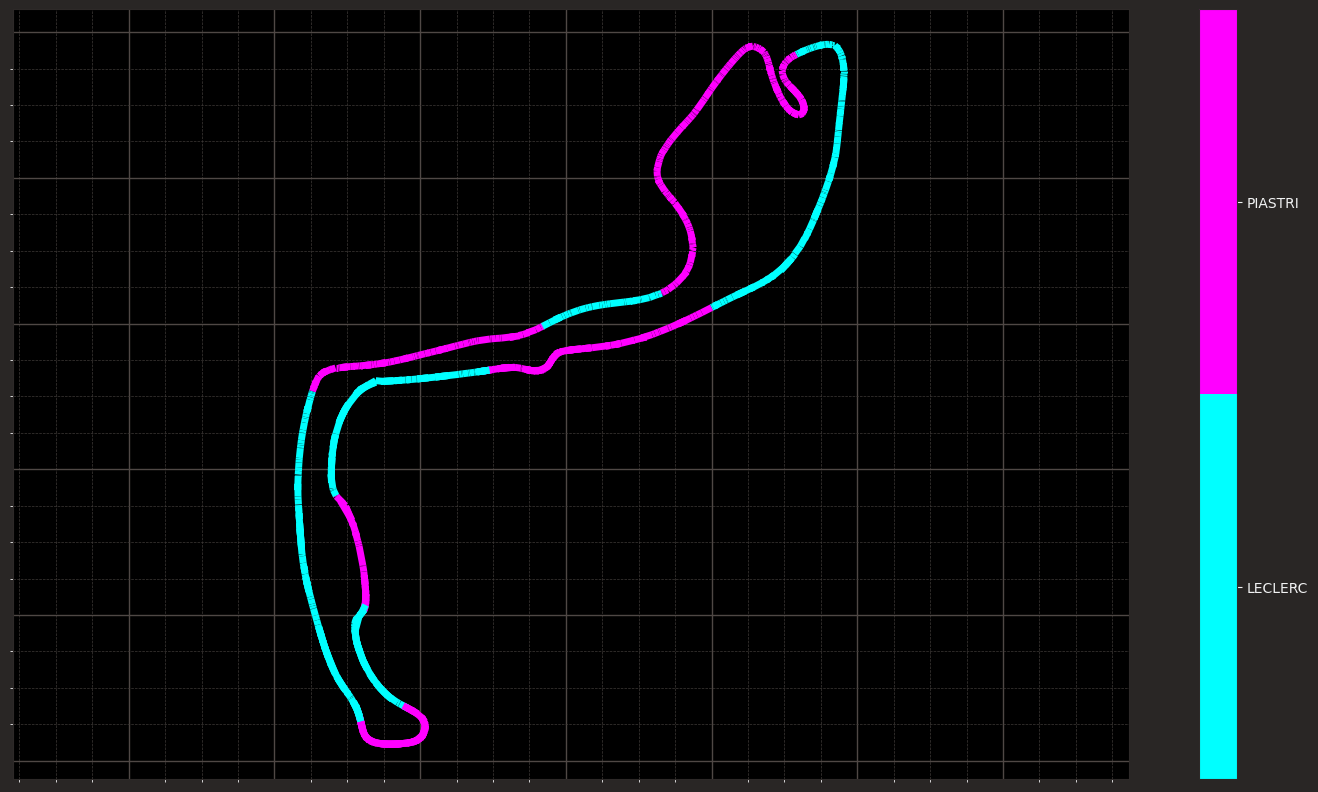

In [216]:
x=np.array(telemetry['X'].values)
y=np.array(telemetry['Y'].values)

points=np.array([x,y]).T.reshape(-1,1,2)
segments=np.concatenate([points[:-1],points[1:]],axis=1)
fastest_driver_array = telemetry['Fastest_Driver_Int'].to_numpy().astype(float)

cmap = cm.get_cmap('cool',2)

lc_comp=LineCollection(segments,norm=plt.Normalize(1,cmap.N+1),cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.figure(figsize=(18, 10))

fig, ax = plt.subplots()
ax.set_facecolor("black")
ax.add_collection(lc_comp)

plt.xlim([x.min(), x.max()])
plt.ylim([y.min(), y.max()])

plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,4))
cbar.set_ticks([1.5, 2.5])
cbar.set_ticklabels(['LECLERC', 'PIASTRI'])

plt.savefig(f"2021_LEC_PIA_Q.png", dpi=300)

plt.show()